In [231]:
import pandas as pd
import numpy as np
import os
from termcolor import colored
from scipy.optimize import least_squares
import pyromat as pm
from scipy.optimize import fsolve
import matplotlib.gridspec as gridspec
from scipy.interpolate import CubicSpline

In [232]:
src_dir = os.path.dirname("CombustionChamber_Nozzle.ipynb")
docs_path = os.path.abspath(os.path.join(src_dir, '..', 'docs', 'data'))

if os.path.isdir(docs_path):
    print(f"{colored('Le fichier ', 'yellow')} {docs_path}, {colored('existe déja !', 'yellow')}")
else:
    os.makedirs(docs_path)

data_dir = docs_path

Le fichier  c:\Users\plamb\Desktop\AeroSpaceChallenge\docs\data, existe déja !


In [233]:
contents = os.listdir(data_dir)
file_name = "Protoxyde d'azote - Éthanol.xlsx"

if file_name in contents:
    target_file_path = os.path.join(data_dir, file_name)
    print(f"Chemin d'accès au fichier :\n{target_file_path}")
else:
    raise FileNotFoundError(f"Le fichier {file_name} est introuvable dans le dossier {data_dir}")

## ===== CRÉATION DU DATAFRAME À PARTIR DU FICHIER .XLSX ===== ##

data = pd.read_excel(
    target_file_path, 
    sheet_name="Feuil1",
    usecols="B:L",
    skiprows=1,
    nrows=27,
)

## ===== ITÉRATION SUR LES COLONNES POUR TROUVER ET REMPLACER LES NaN ===== ##

for col in data.columns:
    if data[col].isna().any():
        data[col] = data[col].fillna(method=('ffill'))

## ===== CRÉATION DU FICHIER .CSV ===== ##
csv_file_name = "Protoxyde_Azote__Ethanol.csv"
data.to_csv(os.path.join(data_dir, csv_file_name), index=False)

Chemin d'accès au fichier :
c:\Users\plamb\Desktop\AeroSpaceChallenge\docs\data\Protoxyde d'azote - Éthanol.xlsx


Équation de combustion :
========================

$$C_2H_6O + 6 N_2O \Rightarrow 2CO_2 + 3H_2O + 6N_2$$

In [234]:
reagent = [
    ('ig.C2H6O', 1), # éthanol, 1 mol
    ('ig.N2O', 6)    # protoxyde d'azote, 6 mol
]

product = [
    ('ig.CO2', 2),   # dioxyde de carbon, 2 mol 
    ('ig.H2O', 3),   # eau, 3 mol
    ('ig.N2', 6)     # diazote, 6 mol
]

T_start = 293.15

## ========== EXPRESSION DE LA TEMPRÉRATURE DE COMBUSTION ADIABATIQUE ========== ##

def enthalpie_totale_molaire(reagent_list, T):
    h_tot = 0
    for name, n in reagent_list:
        gaz = pm.get(name)
        h = gaz.h(T)
        M = gaz.mw() / 1000 
        h_mol = h * M
        h_tot += n * h_mol
    return h_tot

def residu(T, product_list, H_reaction):
    return enthalpie_totale_molaire(product_list, T) - H_reaction

H_reac = enthalpie_totale_molaire(reagent_list=reagent, T=T_start)
T_guess = 3500 
T_ad = fsolve(residu, T_guess, args=(product, H_reac))[0]

print(f"Température adiabatique de combustion :\n    --> {colored(f'T_ad = {T_ad} K', 'yellow')}")

## ========== EXPRESSION DE L'INDICE ADIABATIQUE ========== ##
product = [(name, n, pm.get(name).mw()) for name, n in product]
m_total = sum(n * mw for _, n, mw in product)

cp_reaction, cv_reaction = 0, 0
for name, n, mw in product:
    gaz = pm.get(name)
    y_i = (n * mw) / m_total
    cp_reaction += y_i * gaz.cp(T_ad)
    cv_reaction += y_i * gaz.cv(T_ad)

gamma_reaction = cp_reaction[0] / cv_reaction[0]

print(f"Indice adiabatique issue de la combustion :\n    --> {colored(f'gamma_reaction = {gamma_reaction}', 'yellow')}")

Température adiabatique de combustion :
    --> T_ad = 3993.944756982678 K
Indice adiabatique issue de la combustion :
    --> gamma_reaction = 1.208957789676572


In [235]:
## ========== CONSTANTE SPÉCIFIQUE DE LA RÉACTION ========== ##

R_GP = 8.3145

n_tot = sum(mol for _, mol, _ in product)
Mmol_reaction = 1e-3 * sum(mol * mw for _, mol, mw in product) / n_tot
R_reaction = R_GP / Mmol_reaction

print(f"Masse molaire de la réaction :\n    --> {colored(f'Mmol_reaction = {Mmol_reaction} kg/mol', 'yellow')}")
print(f"Constante spécifique de la réaction :\n     --> {colored(f'R_reaction = {R_reaction} J/kg·K', 'yellow')}")

Masse molaire de la réaction :
    --> Mmol_reaction = 0.028195120000000004 kg/mol
Constante spécifique de la réaction :
     --> R_reaction = 294.8914563938724 J/kg·K


In [236]:
## ========== SÉPARATION DU DATA FRAME POUR CALCUL ========== ##

Thrust_vector = np.array([50.0, 100, 200.0])
ISP_vector = np.array([270.0, 285.0, 300.0])

data_dict = {}
for thrust in Thrust_vector:

    for isp in ISP_vector:
        
        new_dataframe = data[(data['Poussée (kN)'] == thrust) & (data['Isp (s)'] == isp)]
        data_dict[f"data_F_{thrust}_ISP_{isp}"] = new_dataframe

for thrust in Thrust_vector:

    for isp in ISP_vector:

        path_name = f"data_F_{thrust}_ISP_{isp}"
        path = os.path.join(data_dir, path_name)

        if not os.path.isdir(path):
            os.makedirs(path)

        csv_name = path_name + '.csv'
        csv_path = os.path.join(path, csv_name)
        if not os.path.isfile(csv_path):
            data_dict[path_name].to_csv(csv_path, index=False)

In [237]:
chamber_physical_properties = {}
nozzle_physical_properties = {}

def CombustionChamber_System(X_cc, P_cc, T_cc, gamma, R, m_dot, A_star):
    A_cc, M_cc = X_cc

    is_cst = 1 + 0.5 * (gamma - 1) * M_cc**2

    T_cc_local = T_cc * is_cst ** (-1)
    P_cc_local = P_cc * is_cst ** (-gamma / (gamma - 1))
    Rho_cc_local = P_cc_local / (R * T_cc_local)
    V_cc_local = M_cc * np.sqrt(gamma * R * T_cc_local)

    eq1 = Rho_cc_local * A_cc * V_cc_local - m_dot

    aera_ratio = (1/M_cc) * ((2/(gamma+1))*(1+(gamma-1)/2*M_cc**2))**((gamma+1)/(2*(gamma-1)))
    eq2 = (A_cc/A_star) - aera_ratio

    chamber_physical_properties['T_local'] = T_cc_local
    chamber_physical_properties['P_local'] = P_cc_local
    chamber_physical_properties['Rho_local'] = Rho_cc_local
    chamber_physical_properties['V_local'] = V_cc_local

    return [eq1, eq2]

def Nozzle_System(X, P_cc, P_amb, T_cc, gamma, R, m_dot, A_star, Thrust):
    A_noz, M_noz = X

    is_cst = 1 + 0.5 * (gamma - 1) * M_noz**2

    T_noz_local = T_cc * is_cst ** (-1)
    P_noz_local = P_cc * is_cst ** (-gamma / (gamma - 1))
    Rho_noz_local = P_noz_local / (R * T_noz_local)
    V_noz_local = M_noz * np.sqrt(gamma * R * T_noz_local)

    eq1 = m_dot * V_noz_local + (P_noz_local - P_amb) * A_noz - Thrust

    aera_ratio = (1/M_noz) * ((2/(gamma+1))*(1+(gamma-1)/2*M_noz**2))**((gamma+1)/(2*(gamma-1)))
    eq2 = (A_noz/A_star) - aera_ratio

    nozzle_physical_properties['T_local'] = T_noz_local
    nozzle_physical_properties['P_local'] = P_noz_local
    nozzle_physical_properties['Rho_local'] = Rho_noz_local
    nozzle_physical_properties['V_local'] = V_noz_local

    return [eq1, eq2]

In [238]:
theta_conv = np.deg2rad(25)
theta_div = np.deg2rad(15)

for thrust in Thrust_vector:

    for isp in ISP_vector:

        path_name = f"data_F_{thrust}_ISP_{isp}"
        chamber_values_list, col_values_list, nozzle_values_list, length_values_list = [], [], [], []

        for idx, row in data_dict[path_name].iterrows():

            m_dot_tot = row["ṁ total (kg/s)"]

            # ----- Propriétés thermophysiques au niveau de la chambre de combustion ----- #
            Pressure_Chamber = row["Pc (bar)"] * 1e5
            Temperature_Chamber = T_ad
            Rho_Chamber = Pressure_Chamber / (R_reaction * Temperature_Chamber)
            Sound_Velocity_Chamber = np.sqrt(gamma_reaction * (Pressure_Chamber/Rho_Chamber))

            # ----- Propriétés thermophysiques au niveau du col de la tuyère ----- #
            col_ratio = 2 / (gamma_reaction + 1)
            Temperature_star = col_ratio * T_ad
            Pressure_star = (col_ratio ** (gamma_reaction / (gamma_reaction - 1))) * Pressure_Chamber
            Rho_star = (col_ratio ** (1 / (gamma_reaction - 1))) * Rho_Chamber
            velocity_star = np.sqrt(gamma_reaction * R_reaction * Temperature_star)
            
            # ----- Géométrie du col de la tuyère ----- #
            a_star = np.sqrt(gamma_reaction * R_reaction * Temperature_star)
            A_star = m_dot_tot / (Rho_star * velocity_star)
            d_star = np.sqrt((4/np.pi) * A_star)

            # ----- Définition des contraintes ----- #
            d_chamber_constraint = 0.4

            def solve_chamber(P, A_star):
                
                def wrapped(X):
                    return CombustionChamber_System(X, P, Temperature_Chamber, gamma_reaction, R_reaction, m_dot_tot, A_star)
                
                bounds = ([0.005, 0.02], [0.05, 0.08])
                initial_guess = [0.02, 0.05]

                result = least_squares(wrapped, initial_guess, bounds=bounds, xtol=1e-12, ftol=1e-12)

                if result.success:
                    A_chamber, M_chamber = result.x
                    d_chamber = np.sqrt((4/np.pi) * A_chamber)

                    if d_chamber < d_chamber_constraint:

                        valid_chamber_properties = chamber_physical_properties

                        return A_chamber, M_chamber, d_chamber, valid_chamber_properties
                    else:
                        print("\nSolution chambre invalide : diamètre trop grand.")
                        return None
                else:
                    print("\nPas de solution valide pour la chambre.")
                    return None
                
            def solve_nozzle(P, A_star, d_constraint):
                P_amb = 0 

                def wrapped(X):
                    return Nozzle_System(X, P, P_amb, Temperature_Chamber, gamma_reaction, R_reaction, m_dot_tot, A_star, thrust)

                bounds = ([0.1, 1.5], [100.0, 10.0])
                initial_guess = [10.0, 4.0]

                result = least_squares(wrapped, initial_guess, bounds=bounds, xtol=1e-12, ftol=1e-12)

                if result.success:
                    A_nozzle, M_nozzle = result.x
                    d_nozzle = np.sqrt((4/np.pi) * A_nozzle)

                    if d_nozzle > d_constraint * 1.2:

                        valid_nozzle_properties = nozzle_physical_properties

                        return A_nozzle, M_nozzle, d_nozzle, valid_nozzle_properties
                    else:
                        print("\nSolution tuyère trouvée mais diamètre insuffisant.")
                        return None
                else:
                    print("\nPas de solution valide pour la tuyère.")
                    return None


            sol_chamber = solve_chamber(Pressure_Chamber, A_star)
            if sol_chamber:
                A_chamber, M_chamber, d_chamber, valid_chamber_properties = sol_chamber
                A_nozzle, M_nozzle, d_nozzle, valid_nozzle_properties = solve_nozzle(Pressure_Chamber, A_star, d_chamber)

                Pressure_Chamber_local = valid_chamber_properties['P_local']
                Temperature_Chamber_local = valid_chamber_properties["T_local"]
                Rho_Chamber_local = valid_chamber_properties["Rho_local"]
                Velocity_Chamber_local = valid_chamber_properties['V_local']

                Pressure_Nozzle_local = valid_nozzle_properties['P_local']
                Temperature_Nozzle_local = valid_nozzle_properties["T_local"]
                Rho_Nozzle_local = valid_nozzle_properties["Rho_local"]
                Velocity_Nozzle_local = valid_nozzle_properties['V_local']

            ## ===== Conception des DataFrame ===== ##

                    # --> Chambre de combustion
            chamber_values = np.array([Pressure_Chamber, Pressure_Chamber_local, Temperature_Chamber, Temperature_Chamber_local, Rho_Chamber, Rho_Chamber_local, A_chamber, d_chamber, M_chamber, Velocity_Chamber_local])
            chamber_values_list.append(chamber_values)

                    # --> Col de la tuyère
            col_values = np.array([Pressure_star, Temperature_star, Rho_star, A_star, d_star, velocity_star/np.sqrt(gamma_reaction * R_reaction * T_start), velocity_star])
            col_values_list.append(col_values)
                    # --> Sortie des gaz

            nozzle_values = np.array([Pressure_Nozzle_local, Temperature_Nozzle_local, Rho_Nozzle_local, A_nozzle, d_nozzle, M_nozzle, Velocity_Nozzle_local])
            nozzle_values_list.append(nozzle_values)

                    # --> Longueurs du système
            L_star = 1
            L_conv = (d_chamber - d_star) / (2 * np.tan(theta_conv))
            L_div = (d_nozzle - d_star) / (2 * np.tan(theta_div))
            L_chamber = (L_star * A_star) / (np.pi * (d_chamber/2)**2)
            length_values = np.array([L_chamber, L_conv, L_div])
            length_values_list.append(length_values)

        chamber_names = np.array(["Pression is Chambre", "Pression local Chambre", "Temperature is Chambre", "Temperature local Chambre", "Densité is Chambre", "Densité local Chambre", "Section Chambre", "Diamètre Chambre", "Mach Chambre", "Vitesse Chambre"])
        chamber_values_array = np.vstack(chamber_values_list)

        col_names = np.array(["Pression col", "Temperature col", "Densité col", "Section col", "Diamètre col", "Mach col", "Vitesse col"])
        col_values_array = np.vstack(col_values_list)

        nozzle_names = np.array(["Pression tuyère", "Temperature Tuyère", "Densité Tuyère", "Section Tuyère", "Diamètre Tuyère", "Mach Tuyère", "Vitesse Tuyère"])
        nozzle_values_array = np.vstack(nozzle_values_list)

        length_names = np.array(["Longueur Chambre Combustion", "Longueur Convergent", "Longueur Divergent"])
        length_values_array = np.vstack(length_values_list)

        constant_names = np.array(["Thrust", "ISP", 'm_dot'])
        constant_values = np.hstack((np.full((3, 1), thrust), np.full((3, 1), isp), np.full((3, 1), m_dot_tot)))

        columns_names = np.hstack((constant_names, chamber_names, col_names, nozzle_names, length_names))
        columns_values = np.hstack((constant_values, chamber_values_array, col_values_array, nozzle_values_array, length_values_array))

        DataFrame = pd.DataFrame(
            columns_values, 
            columns=columns_names
        )

        csv_name = f"output_sim_F_{thrust}_ISP_{isp}.csv"
        save_path = os.path.join(path_name, csv_name)
        save_dir = os.path.join(data_dir, save_path)

        DataFrame.to_csv(save_dir, index=False)

In [239]:
import pyromat as pm

n2 = pm.get('ig.N2')
c2h6o = pm.get('ig.C2H6O')

T_ad = T_ad
pression = np.array([20e5, 40e5, 60e5])

for P in pression:
    cp_n2 = n2.cp(T_ad, P)[0] * 1e3
    cp_c2h60 = c2h6o.cp(T_ad, P)[0] * 1e3
    gamma_n2 = n2.gam(T_ad, P)[0]
    gamma_c2h6o = c2h6o.gam(T_ad, P)[0]
    print(f"+-----+ Pression = {P} +-----+")
    print(f"    - {colored('Cp de n2 :', 'green')} {cp_n2}")
    print(f"    - {colored('Gamma n2 :', 'green')} {gamma_n2}")
    print(f"    - {colored('Cp de c2h6o ', 'blue')} {cp_c2h60}")
    print(f"    - {colored('Gamma c2h6o :', 'blue')} {gamma_c2h6o}\n")

+-----+ Pression = 2000000.0 +-----+
    - Cp de n2 : 1338.1941226674587
    - Gamma n2 : 1.285005288835512
    - Cp de c2h6o  4186.422077531853
    - Gamma c2h6o : 1.045052632675349

+-----+ Pression = 4000000.0 +-----+
    - Cp de n2 : 1338.1941226674587
    - Gamma n2 : 1.285005288835512
    - Cp de c2h6o  4186.422077531853
    - Gamma c2h6o : 1.045052632675349

+-----+ Pression = 6000000.0 +-----+
    - Cp de n2 : 1338.1941226674587
    - Gamma n2 : 1.285005288835512
    - Cp de c2h6o  4186.422077531853
    - Gamma c2h6o : 1.045052632675349



In [240]:
import matplotlib.pyplot as plt

In [241]:
thrust, isp = 100.0, 285.0
target_repo = os.path.join(data_dir, f'data_F_{thrust}_ISP_{isp}')
file_list = os.listdir(target_repo)

idx = 2

output_file = next((f for f in file_list if 'output' in f), None)
if output_file == None:
    raise FileNotFoundError("No output founded !")
else:
    full_path = os.path.join(target_repo, output_file)
    target_DataFrame = pd.read_csv(full_path)

pressure_columns_info = np.array([(idx, col) for idx, col in enumerate(target_DataFrame.columns) if 'Pression' in col and not 'is' in col])
temperature_columns_info = np.array([(idx, col) for idx, col in enumerate(target_DataFrame.columns) if 'Temperature' in col and not 'is' in col])
density_columns_info = np.array([(idx, col) for idx, col in enumerate(target_DataFrame.columns) if 'Densité' in col and not 'is' in col])

idx_pression = pressure_columns_info[:, 0].astype(int)
idx_temperature = temperature_columns_info[:, 0].astype(int)
idx_density = density_columns_info[:, 0].astype(int)

pression = np.array(target_DataFrame.iloc[idx, idx_pression])
temperature = np.array(target_DataFrame.iloc[idx, idx_temperature])
density = np.array(target_DataFrame.iloc[idx, idx_density])

In [242]:
target_repo

'c:\\Users\\plamb\\Desktop\\AeroSpaceChallenge\\docs\\data\\data_F_100.0_ISP_285.0'

In [243]:
r_throat = 0.5 * target_DataFrame['Diamètre col'][idx]
r_tuyere = 0.5 * target_DataFrame['Diamètre Tuyère'][idx]
r_chamber = 0.5 * target_DataFrame['Diamètre Chambre'][idx]
L_div = target_DataFrame['Longueur Divergent'][idx]
L_conv = target_DataFrame['Longueur Convergent'][idx]
L_cc = target_DataFrame['Longueur Chambre Combustion'][idx]

x_throat = 0.0
x_inlet = x_throat - L_conv
x_exit = x_throat + L_div
x_chamber_start = x_inlet - L_cc

x_vals_cc = np.linspace(x_chamber_start, x_inlet, 100)
r_vals_cc = np.full_like(x_vals_cc, r_chamber)

dx_c = x_throat - x_inlet
A_conv = np.array([[dx_c**2, dx_c], [0, 1]])
Y_conv = np.array([r_throat - r_chamber, 0])
a_c, b_c = np.linalg.solve(A_conv, Y_conv)
x_vals_conv = np.linspace(x_inlet, x_throat, 200)
r_vals_conv = a_c * (x_vals_conv - x_inlet)**2 + b_c * (x_vals_conv - x_inlet) + r_chamber

dx_d = x_exit - x_throat
A_div = np.array([[dx_d**2, dx_d], [2 * dx_d, 1]])
Y_div = np.array([r_tuyere - r_throat, 0])
a_d, b_d = np.linalg.solve(A_div, Y_div)
x_vals_div = np.linspace(x_throat, x_exit, 200)
r_vals_div = a_d * (x_vals_div - x_throat)**2 + b_d * (x_vals_div - x_throat) + r_throat

x_vals_full = np.concatenate((x_vals_cc, x_vals_conv, x_vals_div))
r_vals_full = np.concatenate((r_vals_cc, r_vals_conv, r_vals_div))

x_offset = x_chamber_start
x_vals_full_shifted = x_vals_full - x_offset

key_x = np.array([x_chamber_start, x_inlet, x_throat, x_exit]) - x_offset
key_r = [r_chamber, r_chamber, r_throat, r_tuyere]

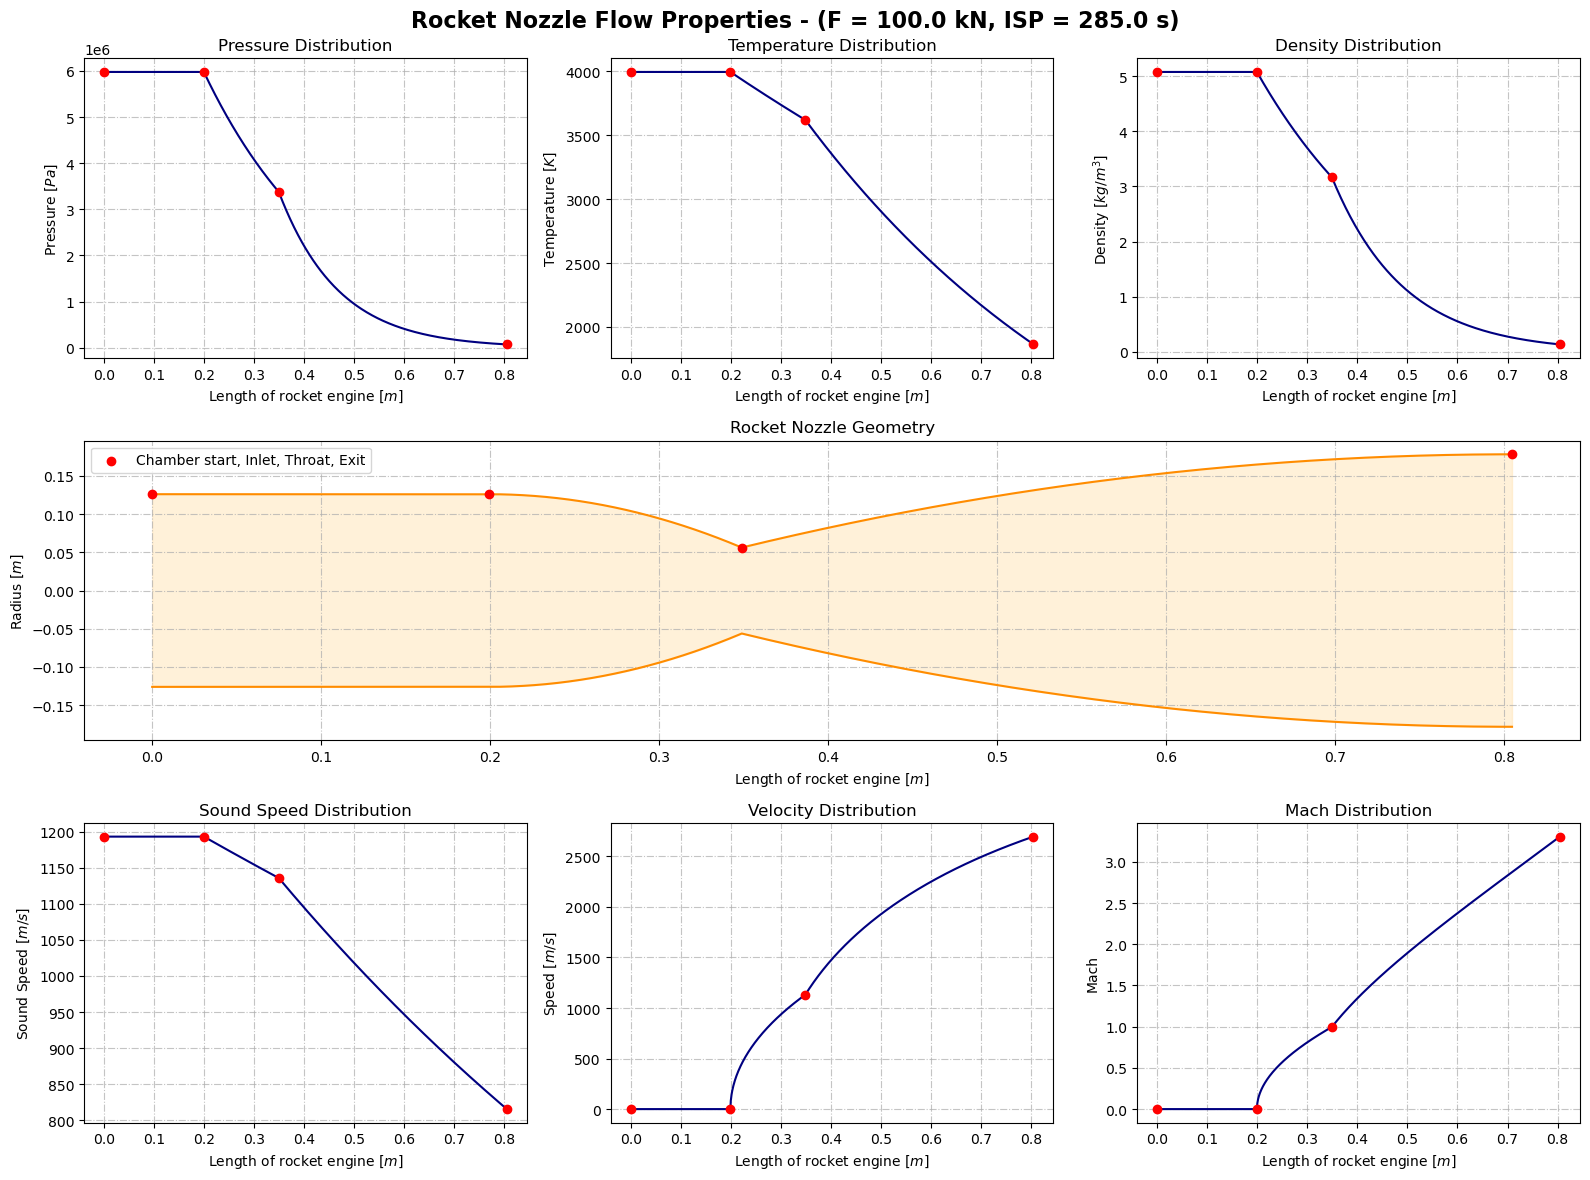

In [ ]:
numPoint_cc = np.argmin(np.abs(x_vals_full_shifted - key_x[1]))
numPoint_conv = np.argmin(np.abs(x_vals_full_shifted - key_x[2])) - numPoint_cc
numPoint_div = np.argmin(np.abs(x_vals_full_shifted - key_x[3])) - numPoint_conv

index = np.array([0, numPoint_cc, numPoint_cc + numPoint_conv, numPoint_cc + numPoint_conv + numPoint_div - 1])

# +-----+ Pressure +-----+ #
x_cc = np.linspace(key_x[0], key_x[1], numPoint_cc)
y_cc_pressure = np.full(shape=numPoint_cc, fill_value=pression[0])

x_conv = np.linspace(key_x[1], key_x[2], numPoint_conv)
y_conv_pressure = pression[0] * (pression[1]/pression[0])**((x_conv - key_x[1])/L_conv)

x_div = np.linspace(key_x[2], key_x[3], numPoint_div)
y_div_pressure = pression[1] * (pression[2]/pression[1])**((x_div - key_x[2])/L_div)

x_array = np.concatenate([x_cc, x_conv, x_div])
y_pressure = np.concatenate([y_cc_pressure, y_conv_pressure, y_div_pressure])

# +-----+ Temperature +-----+ #
y_cc_temperature = np.full(shape=numPoint_cc, fill_value=T_ad)
y_conv_div_temperature = T_ad * (y_pressure[numPoint_cc:]/pression[0]) ** ((gamma_reaction - 1) / gamma_reaction)

y_temperature = np.concatenate([y_cc_temperature, y_conv_div_temperature])

# +-----+ Density +-----#
y_cc_density = np.full(shape=numPoint_cc, fill_value=density[0])
y_conv_div_density = density[0] * (y_pressure[numPoint_cc:]/pression[0]) ** (1 / gamma_reaction)

y_density = np.concatenate([y_cc_density, y_conv_div_density])

# +-----+ Sound velocity +----- #
a_array = np.sqrt(gamma_reaction * R_reaction * y_temperature)

# +-----+ Velocity +-----+ #
v_array = np.sqrt(2 * 1e3 * cp_reaction[0] * (y_temperature[0] - y_temperature))

# +-----+ Mach +-----+ #
Mach_array = v_array / a_array

fig = plt.figure(figsize=(16, 12))
fig.suptitle(f"Rocket Nozzle Flow Properties - (F = {thrust} kN, ISP = {isp} s)", fontsize=16, fontweight='bold')
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1])

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

ax3 = fig.add_subplot(gs[1, :])

ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])
ax6 = fig.add_subplot(gs[2, 2])

# --- Graphique 1 : Pression ---
y_pressure_sample = np.array([y_pressure[0], pression[0], pression[1], pression[2]])
ax0.plot(x_array, y_pressure, color='navy')
ax0.scatter(key_x, y_pressure_sample, color='red', zorder=5)
ax0.set_xlabel(r"Length of rocket engine [$m$]")
ax0.set_ylabel(r"Pressure [$Pa$]")
ax0.set_title("Pressure Distribution")

# --- Graphique 2 : Température ---
y_temperature_sample = np.concatenate([[temperature[0]], temperature])
ax1.plot(x_array, y_temperature, color='navy')
ax1.scatter(key_x, y_temperature_sample, color='red', zorder=5)
ax1.set_xlabel(r"Length of rocket engine [$m$]")
ax1.set_ylabel(r"Temperature [$K$]")
ax1.set_title("Temperature Distribution")

# --- Graphique 3 : Densité ---
y_density_sample = np.concatenate([[density[0]], density])
ax2.plot(x_array, y_density, color='navy')
ax2.scatter(key_x, y_density_sample, color='red', zorder=5)
ax2.set_xlabel(r"Length of rocket engine [$m$]")
ax2.set_ylabel(r"Density [$kg/m^3$]")
ax2.set_title("Density Distribution")

# --- Graphique 4 : Global Plot ---
ax3.plot(x_vals_full_shifted, r_vals_full, color='darkorange')
ax3.plot(x_vals_full_shifted, -r_vals_full, color='darkorange')
ax3.fill_between(x_vals_full_shifted, -r_vals_full, r_vals_full, color='moccasin', alpha=0.5)
ax3.scatter(key_x, key_r, color='red', zorder=5, label='Chamber start, Inlet, Throat, Exit')
ax3.set_xlabel(r"Length of rocket engine [$m$]")
ax3.set_ylabel(r"Radius [$m$]")
ax3.set_title("Rocket Nozzle Geometry")
ax3.legend()

# --- Graphique Sound Velocity ---
a_sample = np.array([a_array[index[0]], a_array[index[1]], a_array[index[2]], a_array[index[3]]])
ax4.plot(x_array, a_array, color='navy')
ax4.scatter(key_x, a_sample, color='red', zorder=5)
ax4.set_xlabel(r"Length of rocket engine [$m$]")
ax4.set_ylabel(r"Sound Speed [$m/s$]")
ax4.set_title("Sound Speed Distribution")

# --- Graphique Velocity ---
v_sample = np.array([v_array[index[0]], v_array[index[1]], v_array[index[2]], v_array[index[3]]])
ax5.plot(x_array, v_array, color='navy')
ax5.scatter(key_x, v_sample, color='red', zorder=5)
ax5.set_xlabel(r"Length of rocket engine [$m$]")
ax5.set_ylabel(r"Speed [$m/s$]")
ax5.set_title("Velocity Distribution")

# --- Graphique Sound Velocity ---
Mach_sample = np.array([Mach_array[index[0]], Mach_array[index[1]], Mach_array[index[2]], Mach_array[index[3]]])
ax6.plot(x_array, Mach_array, color='navy')
ax6.scatter(key_x, Mach_sample, color='red', zorder=5)
ax6.set_xlabel(r"Length of rocket engine [$m$]")
ax6.set_ylabel(r"Mach")
ax6.set_title("Mach Distribution")

# Grids
for ax in [ax0, ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.grid(True, linestyle='-.', alpha=0.75)

plt.tight_layout()

path_name = os.path.join(target_repo, 'FlowProperties.png')
plt.savefig(path_name, dpi=300, transparent=False)

plt.show()